# Demo of SafePredict with cod-rna dataset and Random Forest model

In this demo, we will use online-learning to train a Random Forest model from scikit-learn on the popular cod-rna dataset. We will see how SafePredict can be used to bound the error rate of the predictions made by this model. Finally, we will introduce an artificial change in the data distribution in the middle of the dataset by randomly shuffling the class labels for half of the dataset to show how SafePredict is robust against such dramatic changes in the incoming data. 

## Importing necessary libraries
We import the safePredict method from the SafePredict library, the Random Forest model from scikit-learn, and other supporting libraries 

In [1]:
from SafePredict import safePredict
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Getting the dataset
We use the fetch_openml method provided by scikit-learn to get the cod-rna dataset and store it in two arrays 'X', and 'y' which hold the feature values and class labels respectively. 

Any other dataset can be passed to 'X' and 'y' here (for ex. by reading data from a .csv file), and a list of the datasets available directly from the fetch_openml function can be found here: https://www.openml.org/search?type=data


In [2]:
X=[]
y = []
print("Getting data...")
X, y = fetch_openml('codrna', version=1, return_X_y=True)
print("Received data!")

Getting data...
Received data!


## Feature Engineering

We arbitrarily modify the default class labels for the cod-rna dataset from '-1' and '1' to '0' and '1' respectively to show that feature engineering is compatible with SafePredict.

This part is where you can do exploratory data analysis and feature engineering. 

In [3]:
y = y.astype(float)
y = (y + 1)/2
y = y.astype(int);

## Splitting dataset into train, validation, and test

Here we use scikit-learn methods to split our dataset into distinct datasets that we will use for training, validation, and testing our models. Specifically, we will use 'X' and 'y' for training, 'holdout_X' and 'holdout_y' for testing, and 'rest_X' and 'rest_y' for validation. 

In [4]:
holdout_X, X, holdout_y, y = train_test_split(X, y, train_size=2500/len(y))
scaler = StandardScaler(with_mean=False)
holdout_X = scaler.fit_transform(holdout_X)
X = scaler.transform(X)
X, rest_X, y, rest_y = train_test_split(X, y, train_size=10000/len(y))

## Introducing an artificial change in the incoming data distribution

Here, we simply shuffle the class labels after every change point to make the data meaningless (and thus as if its drawn from a different distribution!)

numCP is the number of change points we want to introduce and that number can be any integer from 0 to T, with T being the size of the test dataset. 

In [5]:
T = holdout_y.size
numCP = 0
if (numCP != 0):
    for i in range(1, numCP + 1):
        permuted_labels = np.random.permutation(np.arange(min(holdout_y[((i)*(T//(numCP+1))):((i+1)*(T//(numCP+1)))]),max(holdout_y[((i)*(T//(numCP+1))):((i+1)*(T//(numCP+1)))])+1))
        for t in range((i)*(T//(numCP+1)),(i+1)*(T//(numCP+1))):
            holdout_y[t] = permuted_labels[holdout_y[t]] 

## Initializing SafePredict

We will set only one parameter for SafePredict which is the target error rate. Info about all the parameters for SafePredict can be found in the README on GitHub: https://github.com/ShanJ35/SafePredict

Epsilon is our target error rate, and here we set it an arbitrary value of 0.05, i.e., we want our error rate to be bounded at 5% of the total number of datapoints SafePredict sees. 

SafePredict uses a default Random Forest classifier as the default base predictor if not provided one by the user which works well for us since we will compare SafePredict using a Random Forest with a Random Forest model by itself.

In [6]:
epsilon = 0.05
sp =safePredict(target_error=epsilon)

## Training SafePredict

In order to simulate online-learning, we will pass one datapoint at a time to SafePredict, and retrain the base predictor every 100 datapoints. 

In [7]:
tau = 100
tl = tau
horizon = X.shape[0]

In [8]:
predictions = []
sp.fit(X[:tl].toarray(),y[:tl])
for t in tqdm(range(tl, horizon)):
    if t % tau == 0:
        sp.estimator_.fit(X[:t], y[:t])
    predictions.append(sp.predict(X[t].toarray(), y[t])[0])

100%|██████████| 9900/9900 [05:43<00:00, 28.83it/s]


## Calculating Error Rate

We will now calculate the error rate for SafePredict, i.e., of the total number of datapoints that SafePredict received, how many it predicted incorrectly. 

In [9]:
errors = 0
counter_sp = 0
error_rates = []
total_preds = len(predictions)
print("Total predictions sp: ", total_preds)
for i in tqdm(range(total_preds)):
    if predictions[i] != (-1):
        if predictions[i] != y[i+tl]:
            errors = errors+1
    counter_sp = counter_sp + 1
    if counter_sp == 0:
        error_rates.append(0)
    else:
        error_rates.append(errors/counter_sp)
        

100%|██████████| 9900/9900 [00:00<00:00, 210338.78it/s]

Total predictions sp:  9900


## Repeating experiment for Random Forest without SafePredict

We will calculate the error rate when Random Forest is used without SafePredict in a similar online-learning setting

In [10]:
model = RandomForestClassifier()
model.fit(X[:tl].toarray(), y[:tl])

base_predictions = []
for t in tqdm(range(tl, horizon)):
    if t%tau == 0:
        model.fit(X[:t].toarray(), y[:t])
    base_predictions.append(model.predict(X[t].toarray())[0])

base_err = 0
counter = 0
base_error_rates = []
total_base_preds = len(base_predictions)
for i in tqdm(range(total_base_preds)):
    if base_predictions[i] != y[i+tl]:
        base_err = base_err+1
    counter = counter + 1
    base_error_rates.append(base_err/counter)

100%|██████████| 9900/9900 [00:00<00:00, 1289032.68it/s]


## Plotting error rates

We will now plot the error rates to show that the use of SafePredict bounds the error rate to the provided threshold. Especially after around 5000 samples, when the change point is introduced, we show that Random Forest by itself greatly increases in its error rate whereas SafePredict is robust against such changes and respects the error rate threshold

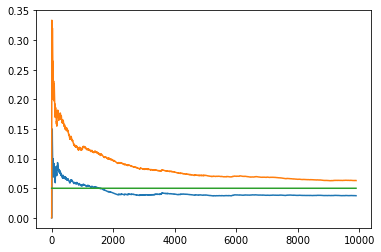

In [11]:
threshold = []
for i in range(total_preds):
    threshold.append(epsilon)
plt.plot(np.linspace(0,total_preds, total_preds), error_rates)
plt.plot(np.linspace(0,total_preds, total_preds), base_error_rates)
plt.plot(np.linspace(0,total_preds, total_preds), threshold)
plt.show()